# Processing of the Example Image Set

The images are captured using Davis10 and 3 Phantom VEO 710-L cameras, each equipped with ZEISS Milvus 2/100 mm Planar optics. The image set is stored in the Davis10 specific format and can be loaded using the `lvpyio` package provided by _LaVision_.

In [1]:
# append parent directory to path to load laser_cross_detection module
import sys
sys.path.insert(0, "..")

from pathlib import Path
from collections import defaultdict
import lvpyio
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np

import laser_cross_detection as lcd


# define set file
set_path = Path(
    "./Example-Data/dev_normal.set"
)
assert set_path.exists(), f"file {set_path} does not exists"

# load set file
image_set = lvpyio.read_set(set_path)
N_IMAGES = len(image_set)

# helper function to access images
def get_image(frame_number, cam_number):
    return image_set[frame_number][0][cam_number][0]["PIXEL"]


## Compute the intersections

In [2]:
images = []
results = defaultdict(list)

for img_idx in range(N_IMAGES):
    for cam_idx in tqdm(range(3), desc=f"image set {img_idx + 1} of {N_IMAGES}"):
        image = get_image(img_idx, cam_idx)
        images.append(image)
        for method in [lcd.core.Kluwe(start_angle=-45), lcd.core.Hough(), lcd.core.Ransac()]:
            intersection = method(image)
            results[method.__class__.__qualname__].append(intersection)


image set 7 of 7: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


## Visualize Results

Due to the random elements of the Probabilistic Hough Transform and RANSAC method, the results may differ between different evaluations.

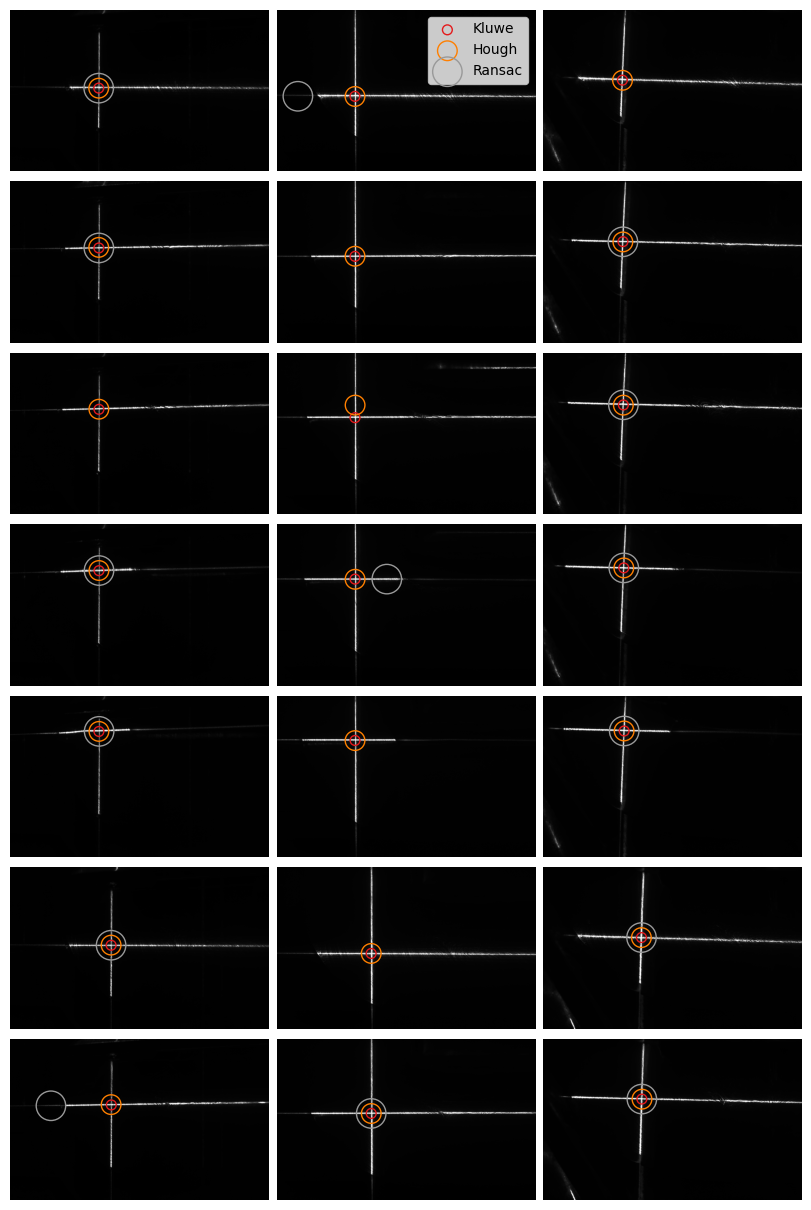

In [3]:
fig, axs = plt.subplots(
    N_IMAGES,
    3,
    sharex=True,
    sharey=True,
    figsize=(8, 12),
    layout="constrained",
)

colors = plt.cm.Set1(np.linspace(0, 1, len(results)))

for i , ax in enumerate(axs.ravel()):
    ax.axis(False)
    ax.imshow(images[i], cmap="gray")

    for j, (key, value) in enumerate(results.items()):
        intersection = value[i]

        # check if the detection is outside of the image
        if any(intersection < 0) or any(intersection > images[0].shape):
            continue
        ax.scatter(*intersection, s=(j+1)**2*50, fc="none", ec=colors[j], label=key)


axs[0,1].legend()